In [1]:
import sys
import pandas as pd
import numpy as np
from scipy.special import gamma, gammaln
import math
from collections import defaultdict
import itertools

import networkx as nx

In [2]:
counts = None
variables = None
variable_values = dict()

In [71]:
PROJ_DIR = '~/Desktop/CS 238/AA228-CS238-Student/project1/'
D = pd.read_csv(PROJ_DIR + 'data/small.csv')
D.head()

,age,portembarked,fare,numparentschildren,passengerclass,sex,numsiblings,survived
0,1,1,1,1,1,1,1,1
1,2,2,1,1,2,2,1,2
2,1,1,1,1,1,2,1,2
3,2,1,1,1,2,2,1,2
4,2,1,1,1,1,1,1,1


In [4]:
variables = list(D.columns)
for var in variables:
    num_values = D[var].max()
    variable_values[var] = num_values

In [29]:
def random_directed_graph(p=0.2):
    G = nx.DiGraph()
    G.add_nodes_from(variables)
    edges = itertools.permutations(variables, 2)
    for e in edges:
        if np.random.uniform() < p:
            G.add_edge(*e)
    return G

In [14]:
def is_cyclic(G):
    try: 
        nx.find_cycle(G, orientation='original')
    except nx.exception.NetworkXNoCycle:
        return False
    
    return True

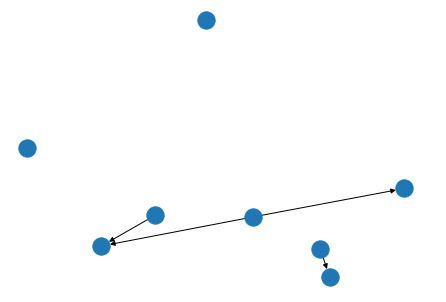

In [30]:
G = random_directed_graph()
while is_cyclic(G):
    G = random_directed_graph()
nx.draw(G)

In [31]:
def populate_counts(G, D):
    # because gamma(1)/gamma(1) = 1, and log 1 = 0, 
    # we don't need to care about the "missing" instantiations because they amount to 0 in the bayesian score

    n = len(variables)
    counts = dict()
    for index, row in D.iterrows():
        for i in range(n):
            i = i   
            var_name = variables[i]
            parents = [var_name_ for var_name_ in G.predecessors(var_name)]
            j = idx2dto1d(row, var_name, parents)
            k = row[var_name]
            if i not in counts:
                counts[i] = dict()
            if j not in counts[i]:
                counts[i][j] = defaultdict(int)
            counts[i][j][k] += 1
    return counts

In [32]:
def idx2dto1d(row, var_name, parents):
    if len(parents) == 0:
        return 0

    j = []
    shape = []
    for var_name_ in variables:
        if var_name_ != var_name and var_name_ in parents:
            j.append(row[var_name_]-1)
            shape.append(variable_values[var_name_])
    return np.ravel_multi_index(j, tuple(shape))

In [33]:
counts = populate_counts(G, D)
# check if counts as a global variable is actually changed in the script code

In [52]:
def bayesian_score(G, D):
    # drop log P(G)
    n = len(variables)
    res = 0
    for i in range(n):
        component = 0
        for j in counts[i]:
            # all pseudo counts are 1
            alpha_sum = variable_values[variables[i]]
            m_sum = np.sum([counts[i][j][k] for k in counts[i][j]])
            component += gammaln(alpha_sum) - gammaln(alpha_sum + m_sum)
            for k in counts[i][j]:
                alpha_ijk = 1 
                m_ijk = counts[i][j][k]
                component += gammaln(alpha_ijk + m_ijk) - gammaln(alpha_ijk)
        res += component
    return res

In [35]:
y = bayesian_score(G, D)
print(y)

-4190.424122887844


In [53]:
def rand_graph_neighbor(G):
    nodes = list(G.nodes)
    edges = list(G.edges)
    i = np.random.randint(len(nodes))
    j = (i + np.random.randint(1, len(nodes))) % len(nodes)
    G_ = G.copy()
    if (nodes[i], nodes[j]) in edges:
        G_.remove_edge(nodes[i], nodes[j])
        update_counts(G_, D, nodes[j])
    else:
        G_.add_edge(nodes[i], nodes[j])
        update_counts(G_, D, nodes[j])
    return G_

In [54]:
def update_counts(G, D, var_name):
    # do dynamic programming to propagate the change in parents?
    n = len(variables)
    parents = G.predecessors(var_name)
    i = variables.index(var_name)
    counts[i] = dict()
    for index, row in D.iterrows():
        parents = [var_name_ for var_name_ in G.predecessors(var_name)]
        j = idx2dto1d(row, var_name, parents)
        k = row[var_name]
        if j not in counts[i]:
            counts[i][j] = defaultdict(int)
        counts[i][j][k] += 1

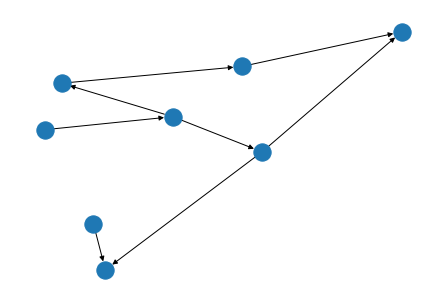

In [55]:
k_max = 20
for k in range(k_max):
    G_ = rand_graph_neighbor(G)
    if is_cyclic(G_):
        y_ = float('-inf')
    else:
        y_ = bayesian_score(G_, D)
    if y_ > y:
        y, G = y_, G_
nx.draw(G)

In [68]:
def write_gph(dag, filename):
    with open(filename, 'w') as f:
        for edge in dag.edges():
            f.write("{}, {}\n".format(edge[0], edge[1]))

In [69]:
outfile = 'small.gph'
write_gph(G, outfile)

FileNotFoundError: [Errno 2] No such file or directory: '~/Desktop/CS 238/AA228-CS238-Student/project1/small.gph'